In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from u8timeseries.timeseries import TimeSeries
from u8timeseries.models import RNNModel, ExponentialSmoothing
from u8timeseries.preprocessing import Transformer
from u8timeseries.metrics import mape
from u8timeseries.utils import TimeSeriesDataset1D
from u8timeseries.utils.statistics import check_seasonality, plot_acf

### Some hyper-parameters:

In [7]:
# Number of previous time stamps taken into account.
SEQ_LENGTH = 12
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

## Air Passenger Example

In [8]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Transformer()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In [9]:
my_model = RNNModel('LSTM', OUTPUT_LEN, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                    batch_size=16, n_epochs=400, optimizer_kwargs={'lr': 1e-3}, 
                    model_name='Air_RNN', log_tensorboard=True)

In [10]:
my_model.fit(train_transformed, val_transformed, verbose=True)  # 107

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead



Training loss: 0.0085, validation loss: 0.0211


### Look at predictions on the validation set
Use the "current" model:

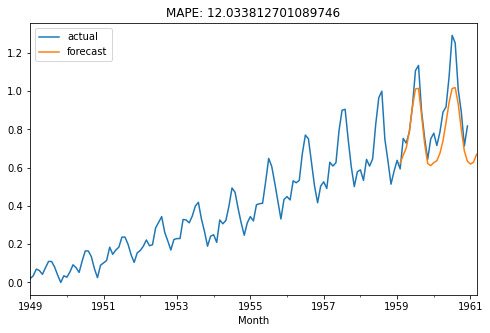

In [11]:
def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {}'.format(mape(pred_series.slice_intersect(val_transformed), val_transformed)))
    plt.legend();
    
eval_model(my_model)

Use the best model obtained over training, according to validation loss:

loading model_best_390.pth.tar


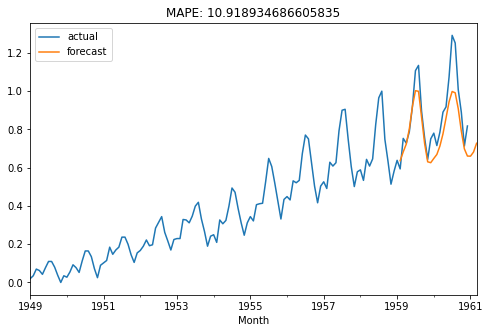

In [12]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(best_model)

### Backtesting

In [13]:
from u8timeseries.backtesting import simulate_forecast_ar

my_model = RNNModel('RNN', OUTPUT_LEN, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                    batch_size=32, n_epochs=200, optimizer_kwargs={'lr': 1e-3}, 
                    model_name='Air_RNN')

# Perform the actual backtest
backtest_series = simulate_forecast_ar(series_transformed, my_model, pd.Timestamp('19590101'), fcast_horizon_n=6)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead



Text(0.5, 1.0, 'Backtest, starting Jan 1959, with a 6-months horizon')

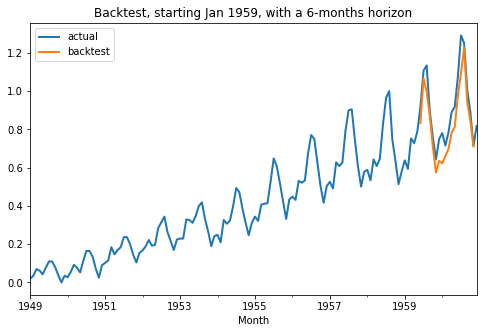

In [14]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual', lw=2)
backtest_series.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtest, starting Jan 1959, with a 6-months horizon')

#### Trials with a longer output length

In [15]:
my_model_gru = RNNModel('GRU', OUTPUT_LEN*4, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=1500, model_name='Air_GRU_out12', log_tensorboard=True)

In [16]:
my_model_gru.fit(train_transformed, val_series=val_transformed, verbose=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead



Training loss: 0.0107, validation loss: 0.0686


Result of training

Test with horizon=28, and feeding predictions

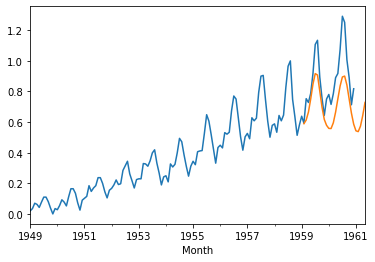

In [17]:
pred_series = my_model_gru.predict(n=28)
series_transformed.plot()
pred_series.plot()

## Monthly sunspot
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



(True, 125)

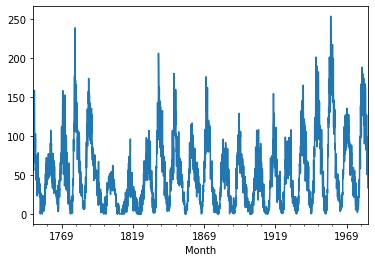

In [18]:
df2 = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series_sunspot = TimeSeries.from_dataframe(df2, 'Month', 'Sunspots')

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

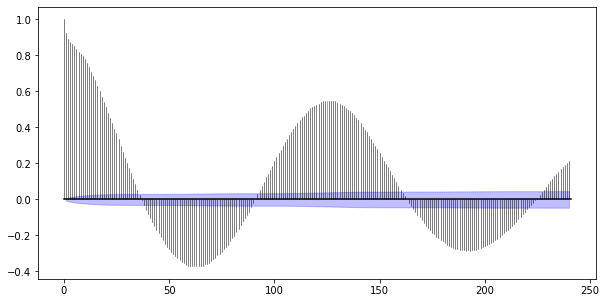

In [19]:
plot_acf(series_sunspot, 125, max_lag=240) # ~11 years seasonality

In [20]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

transformer_sunspot = Transformer()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer.transform(series_sunspot)

In [21]:
SEQ_LENGTH = 125
HIDDEN_SIZE = 10
# OUTPUT_LEN = 50
OUTPUT_LEN = 10
# NUM_LAYERS = 3
NUM_LAYERS = 1

In [22]:
my_model_sun = RNNModel('RNN', OUTPUT_LEN, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=300, model_name='sun_GRU', nr_epochs_val_period=1,
                        optimizer_kwargs={'lr': 1e-3}, log_tensorboard=True)

my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning:

pickle support for Storage will be removed in 1.5. Use `torch.save` instead



Training loss: 0.0154, validation loss: 0.0166


For the sake of comparison, let's also fit an exponential smoothing model:

In [23]:
my_model_ets = ExponentialSmoothing()
my_model_ets.fit(train_sp_transformed)

[2020-05-04 12:31:08,259] INFO | u8timeseries.models.exponential_smoothing | fit function ran for 247 milliseconds


In [24]:
# Compute the predictions with the two models (the RNN can be somewhat slow)
pred_series = my_model_sun.predict(550)
pred_series_ets = my_model_ets.predict(550)

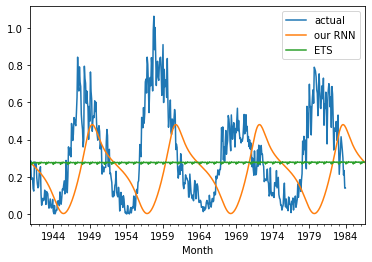

In [25]:
val_sp_transformed.plot(label='actual')
pred_series.plot(label='our RNN')
pred_series_ets.plot(label='ETS')
plt.legend()